### Data analysis for DIA-NN's result on SC-Cycle dataset

In [17]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
plt.style.use('default')
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = 'Arial'

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri, numpy2ri
pandas2ri.activate()
numpy2ri.activate()

#### Check analysis time

In [18]:
report_dir = Path('../../reports/SC-Cycle')
with open(report_dir/'diann_220'/'report.log.txt') as f:
    lines = f.readlines()
    time_str = lines[-2].split(' ')[0][1:-1]
    total_minutes = int(time_str.split(':')[0]) + int(
        time_str.split(':')[-1]) / 60
    n = int(lines[-20].split(' ')[-2])
    t_mean = total_minutes / n
print(f'#runs: {n}, Minutes/Run: {t_mean:.2f}')

#runs: 229, Minutes/Run: 9.54


#### Check the report.parquet
1. #ids
2. miss rate

In [19]:
df_raw = pd.read_parquet(report_dir/'diann_220'/'report.parquet', engine='fastparquet')
n_pgs = df_raw[df_raw['Global.PG.Q.Value'] < 0.01]['Protein.Group'].nunique()
n_prs = df_raw[df_raw['Global.Q.Value'] < 0.01]['Precursor.Id'].nunique()
print(f'Global n_pgs: {n_pgs}, Global n_prs: {n_prs}')

Global n_pgs: 3132, Global n_prs: 17067


In [20]:
df_raw['PG.Quantity'] = df_raw['PG.MaxLFQ'].values
df_raw = df_raw[~df_raw['Protein.Group'].str.contains(';')] # groups not in considering

# no local FDR filtering
df1 = df_raw[df_raw['Global.PG.Q.Value'] < 0.01]
df1 = df1[['Protein.Group', 'Run', 'PG.Quantity']]
df1 = df1.drop_duplicates().reset_index(drop=True)
df1 = df1.pivot(index='Protein.Group', columns='Run', values='PG.Quantity')
miss = df1.isna().sum().sum() / df1.shape[0] / df1.shape[1]
print(f'Only Global FDR filtering, shape: {df1.shape}, miss: {miss:.2f}')

# global & local FDR filtering
df2 = df_raw[(df_raw['Global.PG.Q.Value'] < 0.01) & (df_raw['PG.Q.Value'] < 0.01)]
df2 = df2[['Protein.Group', 'Run', 'PG.Quantity']]
df2 = df2.drop_duplicates().reset_index(drop=True)
df2 = df2.pivot(index='Protein.Group', columns='Run', values='PG.Quantity')
miss = df2.isna().sum().sum() / df2.shape[0] / df2.shape[1]
print(f'Local & Global FDR filtering, shape: {df2.shape}, miss: {miss:.2f}')
df2.columns.name = None
df2.index.name = None
df_protein = df2
df_protein.copy()

Only Global FDR filtering, shape: (3078, 229), miss: 0.48
Local & Global FDR filtering, shape: (3077, 229), miss: 0.53


,20201009_TIMS04_Evo07_AnBr_1Cell_HeLa_NB_01_S3-G2_1_3873,20201009_TIMS04_Evo07_AnBr_1Cell_HeLa_NB_02_S3-G3_1_3874,20201009_TIMS04_Evo07_AnBr_1Cell_HeLa_NB_03_S3-G4_1_3875,20201009_TIMS04_Evo07_AnBr_1Cell_HeLa_NB_04_S3-G5_1_3876,20201009_TIMS04_Evo07_AnBr_1Cell_HeLa_NB_05_S3-G6_1_3877,20201009_TIMS04_Evo07_AnBr_1Cell_HeLa_NB_06_S3-G7_1_3878,20201009_TIMS04_Evo07_AnBr_1Cell_HeLa_NB_10_S3-G11_1_3882,20201009_TIMS04_Evo07_AnBr_1Cell_HeLa_NB_11_S3-G12_1_3883,20201009_TIMS04_Evo07_AnBr_1Cell_HeLa_NB_15_S3-H5_1_3888,20201009_TIMS04_Evo07_AnBr_1Cell_HeLa_NB_17_S3-H7_1_3890,...,20201121_TIMS04_Evo07_SA_ADB_1cell_HeLa_G1_86_S5-B2_1_4894,20201121_TIMS04_Evo07_SA_ADB_1cell_HeLa_G1_87_S5-B3_1_4895,20201121_TIMS04_Evo07_SA_ADB_1cell_HeLa_G1_88_S5-B4_1_4896,20201121_TIMS04_Evo07_SA_ADB_1cell_HeLa_G1_90_S5-B6_1_4898,20201121_TIMS04_Evo07_SA_ADB_1cell_HeLa_G1_92_S5-B8_1_4900,20201121_TIMS04_Evo07_SA_ADB_1cell_HeLa_G1_93_S5-B9_1_4901,20201121_TIMS04_Evo07_SA_ADB_1cell_HeLa_G1_94_S5-B10_1_4902,20201121_TIMS04_Evo07_SA_ADB_1cell_HeLa_G1_95_S5-B11_1_4903,20201121_TIMS04_Evo07_SA_ADB_1cell_HeLa_G1_96_S5-B12_1_4904,20201121_TIMS04_Evo07_SA_ADB_1cell_HeLa_G1_98_S5-C2_1_4906
A0AVT1,NaN,8768.788086,2412.275879,3414.790527,8830.140625,7916.306641,2240.763184,8246.836914,10532.092773,NaN,...,NaN,NaN,NaN,NaN,4695.673340,NaN,NaN,3295.76123,NaN,3563.727051
A0FGR8,NaN,NaN,1285.872559,NaN,6754.157227,NaN,NaN,3050.498779,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0MZ66,986.21228,NaN,NaN,NaN,3636.737793,1105.453369,NaN,1635.994995,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A1X283,NaN,6739.654297,NaN,2519.188477,14270.836914,8968.746094,NaN,2788.783691,4566.275879,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3606.934326,NaN
A4D1P6,NaN,NaN,NaN,713.819275,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Y6M1,NaN,2476.926270,NaN,997.232971,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2396.010254
Q9Y6M5,NaN,NaN,NaN,NaN,6618.217773,2189.565918,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1838.30127,NaN,NaN,NaN,NaN,NaN,NaN
Q9Y6N5,NaN,NaN,NaN,1902.367310,3089.493896,9122.097656,2640.185791,4243.596191,2781.922607,2586.014648,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Q9Y6V0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,71038.273438,41246.824219,NaN,24519.613281,NaN,29898.876953,NaN,NaN,NaN


#### Convert to cell*protein matrix

In [21]:
df_meta = pd.DataFrame()
df_meta['sample_id'] = 'sample_' + df_raw['Run'].str.split('_').str[-1]
df_meta['treat_id'] = df_raw['Run'].str.split('_').str[-5]
assert set(df_meta['treat_id']) == set(['TB', 'G1', 'G2', 'NB'])
df_meta['treat_id'] = df_meta['treat_id'].replace({'NB': 'G2-M', 'TB': 'G1-S'})
df_meta = df_meta.drop_duplicates().reset_index(drop=True)
df_protein.columns = 'sample_' + df_protein.columns.str.split('_').str[-1]
df_sample = df_protein.T
df_sample = df_sample.merge(df_meta, left_index=True, right_on='sample_id')
df_sample = df_sample.reset_index(drop=True)
df_sample = df_sample[df_sample.columns[::-1]]
df_sample.copy()

,treat_id,sample_id,Q9Y6Y8,Q9Y6V0,Q9Y6N5,Q9Y6M5,Q9Y6M1,Q9Y6K9,Q9Y6K1,Q9Y6K0,...,A6NHQ2,A6NDG6,A5YKK6,A5A3E0,A4FU69,A4D1P6,A1X283,A0MZ66,A0FGR8,A0AVT1
0,G2-M,sample_3873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8783.376953,NaN,NaN,114662.359375,NaN,NaN,NaN,986.212280,NaN,NaN
1,G2-M,sample_3874,3732.786621,NaN,NaN,NaN,2476.926270,4903.024414,NaN,2460.546387,...,29474.822266,7511.246582,4116.859375,760070.750000,NaN,NaN,6739.654297,NaN,NaN,8768.788086
2,G2-M,sample_3875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2587.945557,1683.122314,229997.234375,6116.232422,NaN,NaN,NaN,1285.872559,2412.275879
3,G2-M,sample_3876,5401.528320,NaN,1902.367310,NaN,997.232971,1428.674805,NaN,NaN,...,24483.013672,4880.909180,2020.905518,501577.562500,NaN,713.819275,2519.188477,NaN,NaN,3414.790527
4,G2-M,sample_3877,10498.291992,NaN,3089.493896,6618.217773,NaN,5081.151367,NaN,5188.056152,...,40189.769531,12891.760742,3508.617920,996995.000000,NaN,NaN,14270.836914,3636.737793,6754.157227,8830.140625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,G1,sample_4901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16832.080078,NaN,NaN,159546.593750,NaN,NaN,NaN,NaN,NaN,NaN
225,G1,sample_4902,NaN,29898.876953,NaN,NaN,NaN,NaN,NaN,NaN,...,27421.849609,NaN,NaN,90262.296875,NaN,NaN,NaN,NaN,NaN,NaN
226,G1,sample_4903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3087.101562,NaN,91296.968750,NaN,NaN,NaN,NaN,NaN,3295.761230
227,G1,sample_4904,NaN,NaN,NaN,NaN,NaN,NaN,22681.912109,NaN,...,22999.740234,3344.549316,NaN,178963.265625,NaN,NaN,3606.934326,NaN,NaN,NaN


#### Preprocess
1. drop the high-missingness proteins
2. impute NA with MSnbase method
3. normalization
4. log-transformation

##### drop

In [22]:
cut_miss = 0.7
cols_pg = [col for col in df_sample.columns if not col.endswith('_id')]
cols_id = [col for col in df_sample.columns if col.endswith('_id')]
miss_ratio = df_sample[cols_pg].isna().mean()
cols_pg = miss_ratio[miss_ratio <= cut_miss].index.tolist()
df_sample = df_sample[cols_id + cols_pg]
df_sample.copy()

,treat_id,sample_id,Q9Y6K9,Q9Y6K1,Q9Y6G9,Q9Y6E2,Q9Y6E0,Q9Y6B6,Q9Y6A9,Q9Y6A5,...,O00139,O00116,L0R819,E9PRG8,A6NHQ2,A6NDG6,A5YKK6,A5A3E0,A1X283,A0AVT1
0,G2-M,sample_3873,NaN,NaN,2605.813965,7076.818848,3119.607910,1513.860229,7382.763672,1352.692383,...,1658.716064,NaN,NaN,2618.836182,8783.376953,NaN,NaN,114662.359375,NaN,NaN
1,G2-M,sample_3874,4903.024414,NaN,8166.291016,21388.742188,11790.070312,NaN,20707.763672,3476.234131,...,3806.568604,9669.978516,NaN,5616.848633,29474.822266,7511.246582,4116.859375,760070.750000,6739.654297,8768.788086
2,G2-M,sample_3875,NaN,NaN,2594.709961,NaN,3915.852051,NaN,NaN,NaN,...,NaN,3852.014160,NaN,3527.628174,NaN,2587.945557,1683.122314,229997.234375,NaN,2412.275879
3,G2-M,sample_3876,1428.674805,NaN,6183.837402,10261.086914,11497.921875,NaN,6481.026855,NaN,...,NaN,9810.929688,4957.241211,3618.535156,24483.013672,4880.909180,2020.905518,501577.562500,2519.188477,3414.790527
4,G2-M,sample_3877,5081.151367,NaN,15913.895508,22369.052734,10982.473633,7558.746582,23301.728516,15145.703125,...,3769.090576,11505.994141,NaN,10258.766602,40189.769531,12891.760742,3508.617920,996995.000000,14270.836914,8830.140625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,G1,sample_4901,NaN,NaN,3816.311768,NaN,4862.956543,NaN,NaN,NaN,...,NaN,3591.060791,NaN,NaN,16832.080078,NaN,NaN,159546.593750,NaN,NaN
225,G1,sample_4902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3559.323486,NaN,2429.979980,27421.849609,NaN,NaN,90262.296875,NaN,NaN
226,G1,sample_4903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3087.101562,NaN,91296.968750,NaN,3295.761230
227,G1,sample_4904,NaN,22681.912109,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4484.418945,NaN,NaN,22999.740234,3344.549316,NaN,178963.265625,3606.934326,NaN


##### impute using MSnbase

In [23]:
def impute(df):
    cols_X = df.columns[2:]
    protein_group = cols_X.to_list()
    sample_names = df['sample_id'].to_list()

    df_protein = df[cols_X].values.astype(float).T
    ro.globalenv["data_counts"] = df_protein
    ro.globalenv["protein_group"] = ro.StrVector(protein_group)
    ro.globalenv["sample_names"] = ro.StrVector(sample_names)

    r_script = """
        suppressPackageStartupMessages({
            library(MSnbase)
        })

        data.mat <- as.matrix(data_counts)
        data.mat[is.nan(data.mat)] <- NA
        rownames(data.mat) <- protein_group
        colnames(data.mat) <- sample_names
        msnset <- MSnSet(exprs = data.mat)
        msnset.imputed <- impute(msnset, method = "MinProb")
        data.imputed <- exprs(msnset.imputed)
        """
    ro.r(r_script)

    imputed_r = ro.r("data.imputed")
    imputed_np = np.array(imputed_r)
    imputed_np[imputed_np < 0] = 0
    df[cols_X] = imputed_np.T
    return df
df_sample = impute(df_sample)
df_sample.copy()

R[write to console]: Imputing along margin 2 (samples/columns).



[1] 6507.013


,treat_id,sample_id,Q9Y6K9,Q9Y6K1,Q9Y6G9,Q9Y6E2,Q9Y6E0,Q9Y6B6,Q9Y6A9,Q9Y6A5,...,O00139,O00116,L0R819,E9PRG8,A6NHQ2,A6NDG6,A5YKK6,A5A3E0,A1X283,A0AVT1
0,G2-M,sample_3873,551.254863,0.000000,2605.813965,7076.818848,3119.607910,1513.860229,7382.763672,1352.692383,...,1658.716064,3735.564004,6753.408696,2618.836182,8783.376953,0.000000,6836.374181,114662.359375,7045.487889,4651.635592
1,G2-M,sample_3874,4903.024414,4311.801841,8166.291016,21388.742188,11790.070312,6127.456008,20707.763672,3476.234131,...,3806.568604,9669.978516,0.000000,5616.848633,29474.822266,7511.246582,4116.859375,760070.750000,6739.654297,8768.788086
2,G2-M,sample_3875,7597.632349,2292.819479,2594.709961,0.000000,3915.852051,0.000000,4926.373007,0.000000,...,0.000000,3852.014160,1544.727537,3527.628174,5128.505377,2587.945557,1683.122314,229997.234375,0.000000,2412.275879
3,G2-M,sample_3876,1428.674805,0.000000,6183.837402,10261.086914,11497.921875,0.000000,6481.026855,345.824767,...,0.000000,9810.929688,4957.241211,3618.535156,24483.013672,4880.909180,2020.905518,501577.562500,2519.188477,3414.790527
4,G2-M,sample_3877,5081.151367,0.000000,15913.895508,22369.052734,10982.473633,7558.746582,23301.728516,15145.703125,...,3769.090576,11505.994141,3897.498339,10258.766602,40189.769531,12891.760742,3508.617920,996995.000000,14270.836914,8830.140625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,G1,sample_4901,3742.628775,6623.384233,3816.311768,9244.269692,4862.956543,4576.017450,7293.578408,6918.664052,...,0.000000,3591.060791,0.000000,0.000000,16832.080078,3834.312895,5678.348988,159546.593750,6713.123058,862.291640
225,G1,sample_4902,7515.087377,10071.977357,5150.278527,5870.905916,6836.545905,7625.064987,13981.244502,5074.766357,...,0.000000,3559.323486,0.000000,2429.979980,27421.849609,9886.780100,0.000000,90262.296875,0.000000,0.000000
226,G1,sample_4903,1260.869583,0.000000,7009.660666,9413.350467,2496.481024,0.000000,3818.955799,9231.646111,...,0.000000,5846.351691,3480.925310,8953.198860,0.000000,3087.101562,8155.965160,91296.968750,6802.190721,3295.761230
227,G1,sample_4904,4983.894760,22681.912109,0.000000,5171.516795,5775.879913,2998.314936,1252.738864,78.759833,...,2623.575276,4484.418945,0.000000,5407.865255,22999.740234,3344.549316,0.000000,178963.265625,3606.934326,0.000000


##### normalize

In [24]:
X = df_sample[cols_pg].values
X = 10000 * X / X.sum(axis=1, keepdims=True)
df_sample[cols_pg] = X
df_sample.copy()

,treat_id,sample_id,Q9Y6K9,Q9Y6K1,Q9Y6G9,Q9Y6E2,Q9Y6E0,Q9Y6B6,Q9Y6A9,Q9Y6A5,...,O00139,O00116,L0R819,E9PRG8,A6NHQ2,A6NDG6,A5YKK6,A5A3E0,A1X283,A0AVT1
0,G2-M,sample_3873,0.376603,0.000000,1.780223,4.834694,2.131233,1.034229,5.043707,0.924123,...,1.133191,2.552038,4.613749,1.789119,6.000569,0.000000,4.670429,78.334267,4.813289,3.177873
1,G2-M,sample_3874,0.752838,0.662058,1.253898,3.284146,1.810313,0.940844,3.179585,0.533760,...,0.584482,1.484782,0.000000,0.862442,4.525728,1.153319,0.632125,116.705487,1.034844,1.346408
2,G2-M,sample_3875,3.689901,1.113541,1.260159,0.000000,1.901791,0.000000,2.392565,0.000000,...,0.000000,1.870787,0.750219,1.713244,2.490733,1.256873,0.817433,111.701503,0.000000,1.171557
3,G2-M,sample_3876,0.362757,0.000000,1.570149,2.605410,2.919457,0.000000,1.645609,0.087809,...,0.000000,2.491110,1.258702,0.918789,6.216525,1.239320,0.513132,127.356430,0.639652,0.867055
4,G2-M,sample_3877,0.563239,0.000000,1.764034,2.479580,1.217393,0.837877,2.582966,1.678881,...,0.417799,1.275424,0.432033,1.137171,4.454983,1.429035,0.388926,110.515588,1.581904,0.978810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,G1,sample_4901,1.587841,2.810026,1.619102,3.921958,2.063150,1.941413,3.094361,2.935301,...,0.000000,1.523537,0.000000,0.000000,7.141150,1.626739,2.409087,67.688967,2.848098,0.365834
225,G1,sample_4902,4.064834,5.447830,2.785733,3.175513,3.697818,4.124320,7.562313,2.744889,...,0.000000,1.925202,0.000000,1.314351,14.832199,5.347659,0.000000,48.821958,0.000000,0.000000
226,G1,sample_4903,0.752863,0.000000,4.185456,5.620695,1.490644,0.000000,2.280292,5.512199,...,0.000000,3.490846,2.078454,5.345939,0.000000,1.843303,4.869912,54.513256,4.061576,1.967893
227,G1,sample_4904,2.100812,9.560880,0.000000,2.179898,2.434649,1.263850,0.528055,0.033199,...,1.105890,1.890272,0.000000,2.279524,9.694851,1.409795,0.000000,75.436602,1.520395,0.000000


##### log

In [25]:
df_sample[cols_pg] = np.log2(df_sample[cols_pg] + 1.)
df_sample.copy()

,treat_id,sample_id,Q9Y6K9,Q9Y6K1,Q9Y6G9,Q9Y6E2,Q9Y6E0,Q9Y6B6,Q9Y6A9,Q9Y6A5,...,O00139,O00116,L0R819,E9PRG8,A6NHQ2,A6NDG6,A5YKK6,A5A3E0,A1X283,A0AVT1
0,G2-M,sample_3873,0.461112,0.000000,1.475200,2.544657,1.646731,1.024482,2.595434,0.944201,...,1.093013,1.828647,2.488965,1.479810,2.807472,0.000000,2.503458,6.309872,2.539355,2.062769
1,G2-M,sample_3874,0.809692,0.732971,1.172422,2.099008,1.490731,0.956684,2.063360,0.617073,...,0.664011,1.313119,0.000000,0.897196,2.466165,1.106562,0.706752,6.879038,1.024918,1.230454
2,G2-M,sample_3875,2.229557,1.079662,1.176424,0.000000,1.536943,0.000000,1.762376,0.000000,...,0.000000,1.521446,0.807536,1.440019,1.803530,1.174325,0.861902,6.816363,0.000000,1.118730
3,G2-M,sample_3876,0.446529,0.000000,1.361852,1.850163,1.970654,0.000000,1.403600,0.121425,...,0.000000,1.803686,1.175494,0.940196,2.851304,1.163061,0.597537,7.004012,0.713389,0.900765
4,G2-M,sample_3877,0.644538,0.000000,1.466776,1.798913,1.148864,0.878040,1.841154,1.421631,...,0.503653,1.186136,0.518064,1.095702,2.447575,1.280383,0.473969,6.801102,1.368435,0.984633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,G1,sample_4901,1.371749,1.929801,1.389072,2.299232,1.615016,1.556510,2.033638,1.976474,...,0.000000,1.335447,0.000000,0.000000,3.025233,1.393273,1.769385,6.102006,1.944146,0.449783
225,G1,sample_4902,2.340515,2.688814,1.920573,2.061954,2.231991,2.357361,3.098001,1.904923,...,0.000000,1.548536,0.000000,1.210608,3.984790,2.666225,0.000000,5.638710,0.000000,0.000000
226,G1,sample_4903,0.809713,0.000000,2.374471,2.726983,1.316519,0.000000,1.713824,2.703145,...,0.000000,2.166987,1.622206,2.665834,0.000000,1.507568,2.553339,5.794760,2.339587,1.569439
227,G1,sample_4904,1.632646,3.400658,0.000000,1.668980,1.780163,1.178778,0.611696,0.047118,...,1.074430,1.531205,0.000000,1.713486,3.418845,1.268910,0.000000,6.256192,1.333650,0.000000


#### PCA
- calculating the silhouette score to check the separation

silhouette score: 0.1553


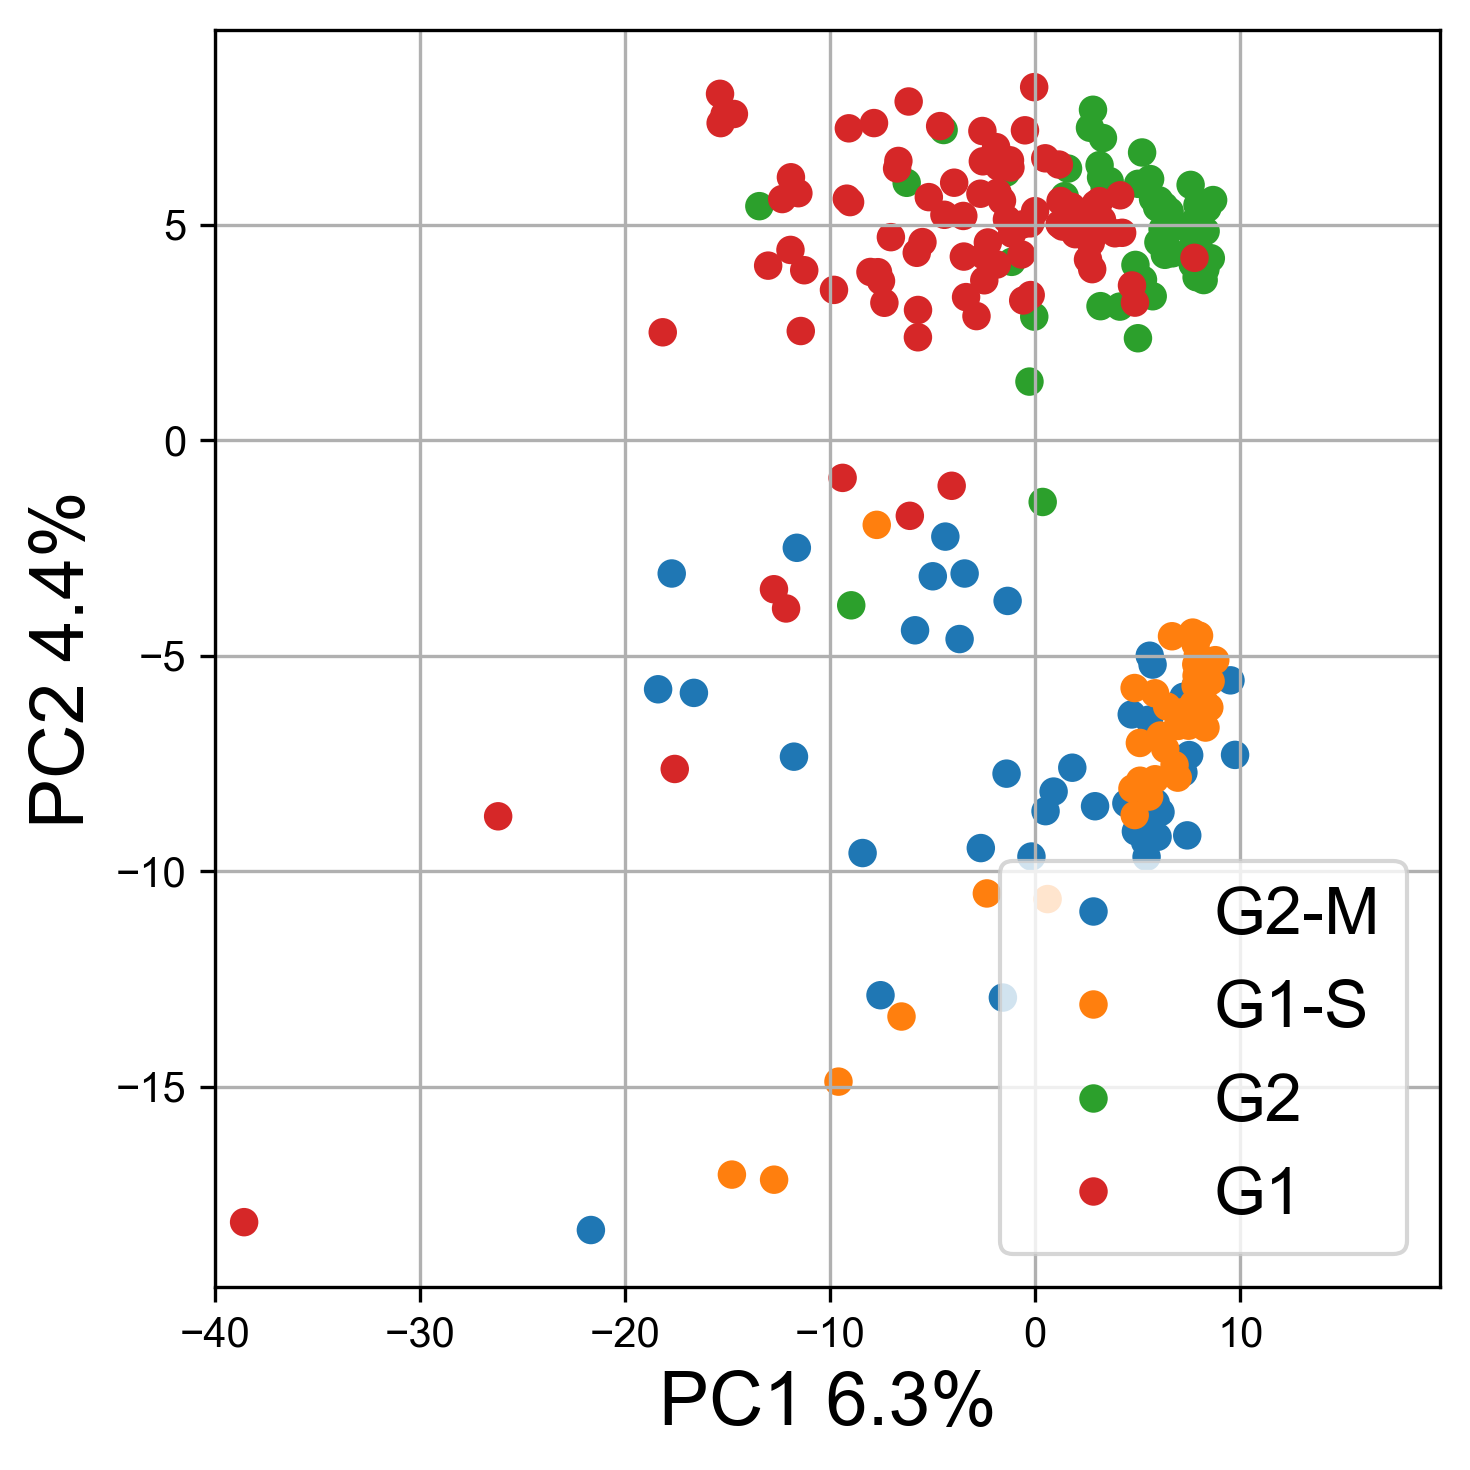

In [26]:
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

data = df_sample[cols_pg].values
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data)

score = silhouette_score(X_pca, df_sample['treat_id'], metric='euclidean')
print(f"silhouette score: {score:.4f}")

df_plot = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'treat_id': df_sample['treat_id'].values
})

plt.figure(figsize=(5, 5))
ax = sns.scatterplot(
    x='PC1', y='PC2', hue='treat_id', data=df_plot,
    s=40,
    edgecolor=None
)
ax.set_xlabel(f'PC1 {pca.explained_variance_ratio_[0] * 100:.1f}%',
              fontsize=18)
ax.set_ylabel(f'PC2 {pca.explained_variance_ratio_[1] * 100:.1f}%',
              fontsize=18)
ax.set_xlim(-40, df_plot['PC1'].max() + 10)
ax.set_ylim(None, None)
ax.grid(True)
plt.legend(title=None, fontsize=16, loc='lower right')
plt.tight_layout()
plt.show()

#### Differential Expression
- G2-M (treat group) vs. G1-S (control group)
- DEP calculation
- Volcano plot

In [27]:
df_sample = df_sample[df_sample['treat_id'].isin(['G1-S', 'G2-M'])].reset_index(drop=True)
n_g2m = sum(df_sample.treat_id == 'G2-M')
n_g1s = sum(df_sample.treat_id == 'G1-S')
print(f'G2-M #cells: {n_g2m}, G1-S #cells: {n_g1s}')
df_sample.copy()

G2-M #cells: 45, G1-S #cells: 41


,treat_id,sample_id,Q9Y6K9,Q9Y6K1,Q9Y6G9,Q9Y6E2,Q9Y6E0,Q9Y6B6,Q9Y6A9,Q9Y6A5,...,O00139,O00116,L0R819,E9PRG8,A6NHQ2,A6NDG6,A5YKK6,A5A3E0,A1X283,A0AVT1
0,G2-M,sample_3873,0.461112,0.000000,1.475200,2.544657,1.646731,1.024482,2.595434,0.944201,...,1.093013,1.828647,2.488965,1.479810,2.807472,0.000000,2.503458,6.309872,2.539355,2.062769
1,G2-M,sample_3874,0.809692,0.732971,1.172422,2.099008,1.490731,0.956684,2.063360,0.617073,...,0.664011,1.313119,0.000000,0.897196,2.466165,1.106562,0.706752,6.879038,1.024918,1.230454
2,G2-M,sample_3875,2.229557,1.079662,1.176424,0.000000,1.536943,0.000000,1.762376,0.000000,...,0.000000,1.521446,0.807536,1.440019,1.803530,1.174325,0.861902,6.816363,0.000000,1.118730
3,G2-M,sample_3876,0.446529,0.000000,1.361852,1.850163,1.970654,0.000000,1.403600,0.121425,...,0.000000,1.803686,1.175494,0.940196,2.851304,1.163061,0.597537,7.004012,0.713389,0.900765
4,G2-M,sample_3877,0.644538,0.000000,1.466776,1.798913,1.148864,0.878040,1.841154,1.421631,...,0.503653,1.186136,0.518064,1.095702,2.447575,1.280383,0.473969,6.801102,1.368435,0.984633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,G1-S,sample_4077,0.921658,0.000000,1.574802,2.311127,1.605465,1.659340,1.786431,1.169582,...,0.653424,1.592985,1.819578,1.548681,3.555783,1.416483,0.563681,4.688537,1.211945,1.025006
82,G1-S,sample_4080,0.752713,0.000000,1.265210,1.587929,1.458817,1.148875,1.955371,1.133187,...,0.574829,1.331149,0.963519,0.696635,3.265618,1.276027,0.615536,4.923030,0.835925,1.176916
83,G1-S,sample_4083,0.893759,1.549146,1.135369,2.202365,1.596021,1.302833,0.000000,0.000000,...,0.490490,1.476641,0.608405,0.704728,3.331847,0.835139,0.622542,4.738284,0.873749,1.160354
84,G1-S,sample_4086,0.867751,1.816935,1.564140,2.074153,1.370451,0.979646,1.367905,0.587797,...,0.586278,1.547045,0.685891,0.946197,3.246417,1.037693,0.669044,5.235034,0.939328,1.002818


In [28]:
# calculating: p, adj p, fc
from scipy import stats
import statsmodels.stats.multitest

pvalues = []
protein_names = []
mean_0_v, mean_1_v = [], []
for pg in cols_pg:
    x_treat = df_sample.loc[df_sample.treat_id == 'G2-M', pg].values
    x_control = df_sample.loc[df_sample.treat_id == 'G1-S', pg].values
    t_val, p_val = stats.ttest_ind(x_treat, x_control, equal_var=False)
    mean_0_v.append(np.mean(x_treat))
    mean_1_v.append(np.mean(x_control))
    pvalues.append(np.float32(p_val))
    protein_names.append(pg)
df_dep = pd.DataFrame({
    'protein_id': protein_names,
    'mean_treat': mean_0_v,
    'mean_control': mean_1_v,
    'pval': pvalues
})
df_dep['pval'] = df_dep['pval'].fillna(np.float32(1))
_, adj_pvals, _, _ = statsmodels.stats.multitest.multipletests(
    df_dep['pval'], alpha=0.05, method="fdr_bh")
df_dep['adj_pval'] = adj_pvals
df_dep['log_fc'] = df_dep['mean_treat'] - df_dep['mean_control']
df_dep.copy()

,protein_id,mean_treat,mean_control,pval,adj_pval,log_fc
0,Q9Y6K9,0.946157,0.754827,0.182066,0.409715,0.191330
1,Q9Y6K1,0.675470,0.658545,0.918981,0.953918,0.016926
2,Q9Y6G9,1.395998,1.417923,0.843928,0.916404,-0.021925
3,Q9Y6E2,1.766971,1.895886,0.345418,0.571150,-0.128916
4,Q9Y6E0,1.422906,1.383965,0.659620,0.811347,0.038941
...,...,...,...,...,...,...
1879,A6NDG6,1.185379,1.063641,0.237594,0.464826,0.121738
1880,A5YKK6,0.882979,0.630841,0.053827,0.202911,0.252139
1881,A5A3E0,4.661464,5.764017,0.004577,0.044452,-1.102553
1882,A1X283,0.716429,0.790331,0.527681,0.719230,-0.073902


In [29]:
# assign up and down
cut_fc, cut_p = 0.2, 0.05
df_dep['state'] = 'none'
idx_up = (df_dep['log_fc'] > cut_fc) & (df_dep['adj_pval'] < cut_p)
idx_down = (df_dep['log_fc'] < -cut_fc) & (df_dep['adj_pval'] < cut_p)
df_dep.loc[idx_up, 'state'] = 'up'
df_dep.loc[idx_down, 'state'] = 'down'
n_neg = sum(df_dep['log_fc'] < 0)
n_pos = sum(df_dep['log_fc'] > 0)
n_down = sum(df_dep['state'] == 'down')
n_up = sum(df_dep['state'] == 'up')
print(f'left area: {n_down}/{n_neg}, right area: {n_up}/{n_pos}')
df_dep.copy()

left area: 133/868, right area: 68/1016


,protein_id,mean_treat,mean_control,pval,adj_pval,log_fc,state
0,Q9Y6K9,0.946157,0.754827,0.182066,0.409715,0.191330,none
1,Q9Y6K1,0.675470,0.658545,0.918981,0.953918,0.016926,none
2,Q9Y6G9,1.395998,1.417923,0.843928,0.916404,-0.021925,none
3,Q9Y6E2,1.766971,1.895886,0.345418,0.571150,-0.128916,none
4,Q9Y6E0,1.422906,1.383965,0.659620,0.811347,0.038941,none
...,...,...,...,...,...,...,...
1879,A6NDG6,1.185379,1.063641,0.237594,0.464826,0.121738,none
1880,A5YKK6,0.882979,0.630841,0.053827,0.202911,0.252139,none
1881,A5A3E0,4.661464,5.764017,0.004577,0.044452,-1.102553,down
1882,A1X283,0.716429,0.790331,0.527681,0.719230,-0.073902,none


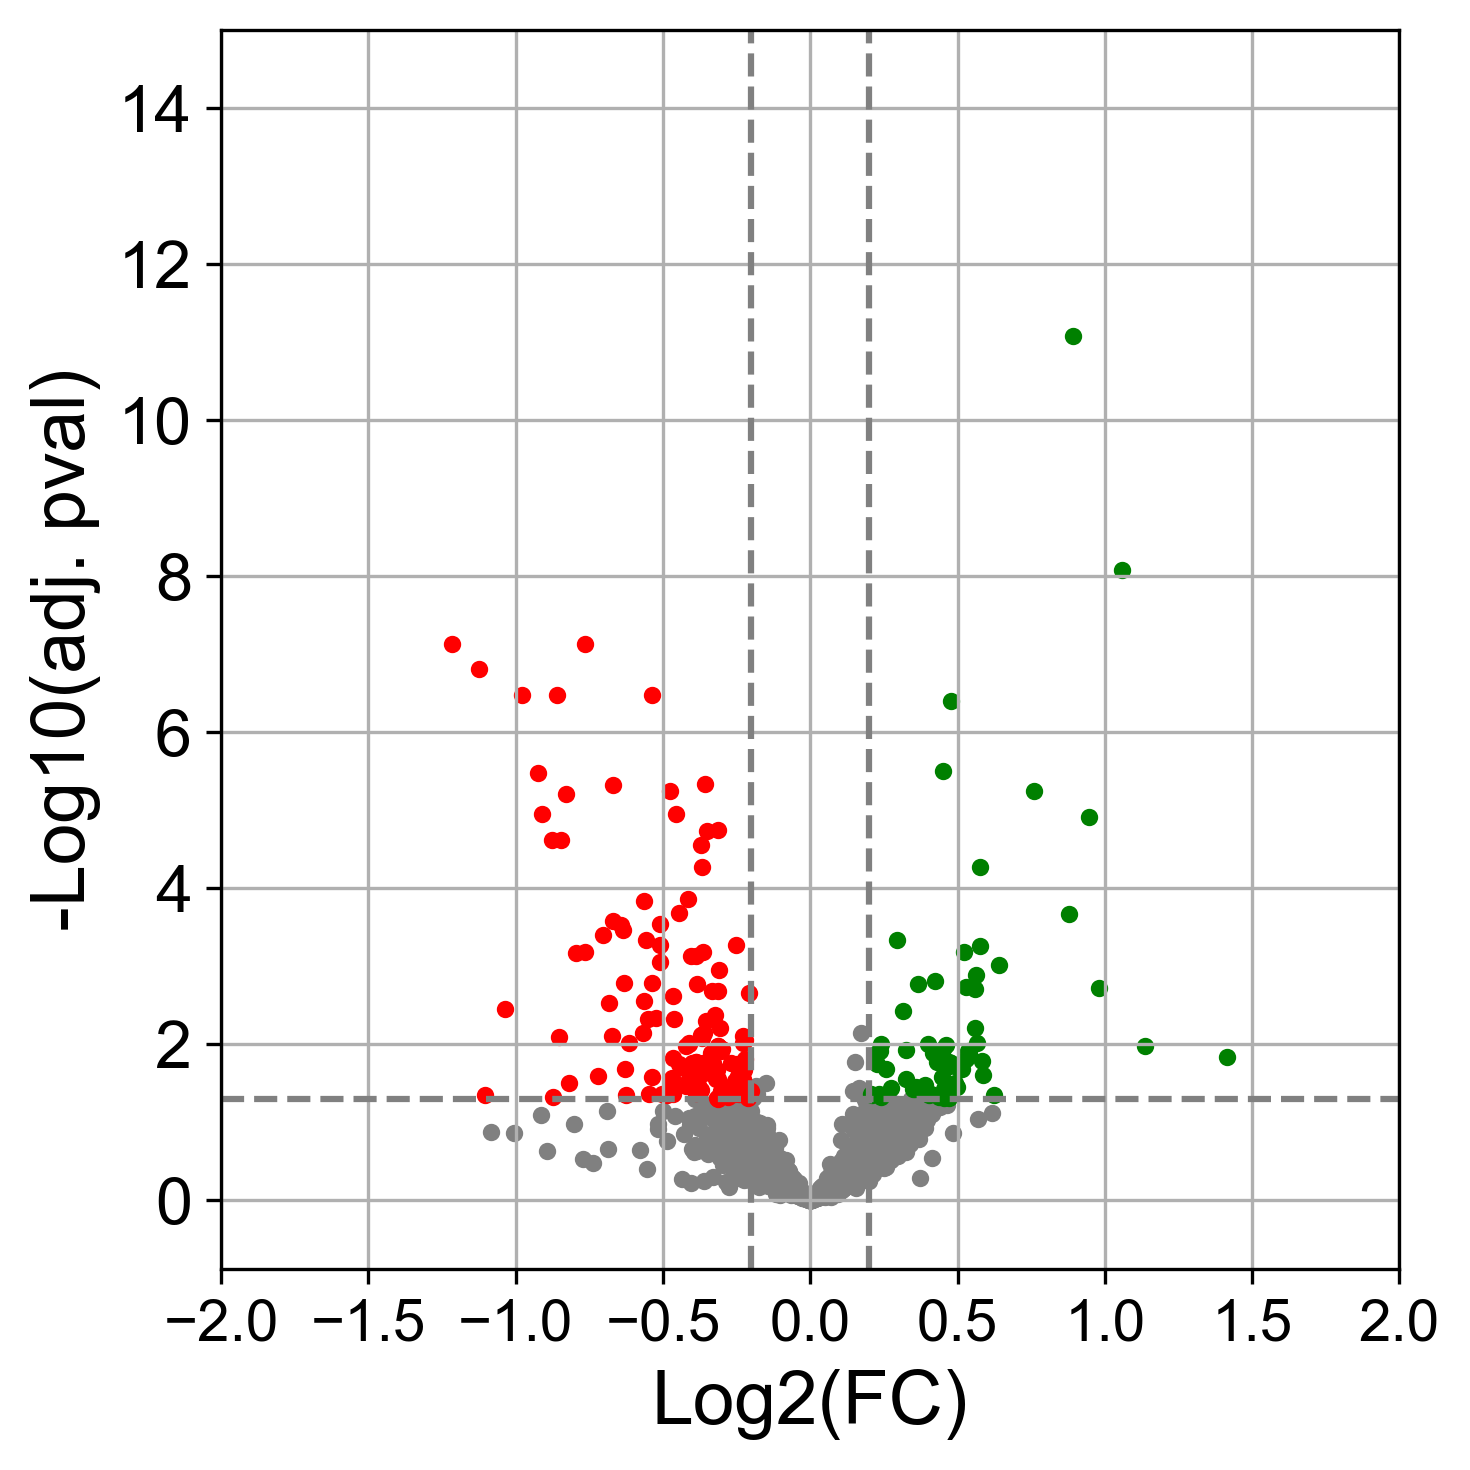

In [30]:
# valcano plot
df_dep['Y'] = -np.log10(df_dep['adj_pval'])
plt.figure(figsize=(5, 5))

df_none = df_dep[df_dep['state'] == 'none']
plt.scatter(x=df_none['log_fc'],
            y=df_none['Y'],
            s=10, label="Not significant", color='grey')

df_up = df_dep[df_dep['state'] == 'up']
df_down = df_dep[df_dep['state'] == 'down']
plt.scatter(x=df_down['log_fc'],
            y=df_down['Y'],
            s=10, color="red")
plt.scatter(x=df_up['log_fc'],
            y=df_up['Y'],
            s=10, color="green")

plt.axvline(cut_fc, color="grey", linestyle="--")
plt.axvline(-cut_fc, color="grey", linestyle="--")
plt.axhline(-np.log10(cut_p), color="grey", linestyle="--")

plt.ylabel("-Log10(adj. pval)", fontsize=18)
plt.xlabel("Log2(FC)", fontsize=18)
plt.xticks(fontweight='light', fontsize=14)
plt.yticks(fontweight='light', fontsize=16)

plt.grid(True)
plt.xlim(-2, 2)
plt.ylim(None, 15)
plt.tight_layout()
plt.show()

#### Pathway Analysis

In [31]:
# pg --> gene
protein_ids, gene_names, is_isoforms = [], [], []
with open(report_dir/'meta'/'swissprot_UP5640_human_20420_20240619.fasta', 'r') as fasta_file:
    for line in fasta_file:
        line = line.strip()
        if line.startswith(">"):
            protein_id = line.split('|')[1]
            gene_name = None
            for field in line.split():
                if field.startswith("GN="):
                    gene_name = field.split("=")[1]
                    break
            protein_ids.append(protein_id)
            gene_names.append(gene_name)
            is_isoforms.append(line.__contains__('isoform'))
df_map = pd.DataFrame({
    "protein_id": protein_ids, "gene": gene_names
})
df_map = df_map.dropna().reset_index(drop=True)
df_gene = pd.merge(df_dep, df_map, on='protein_id')
df_gene.copy()

,protein_id,mean_treat,mean_control,pval,adj_pval,log_fc,state,Y,gene
0,Q9Y6K9,0.946157,0.754827,0.182066,0.409715,0.191330,none,0.387518,IKBKG
1,Q9Y6K1,0.675470,0.658545,0.918981,0.953918,0.016926,none,0.020489,DNMT3A
2,Q9Y6G9,1.395998,1.417923,0.843928,0.916404,-0.021925,none,0.037913,DYNC1LI1
3,Q9Y6E2,1.766971,1.895886,0.345418,0.571150,-0.128916,none,0.243249,BZW2
4,Q9Y6E0,1.422906,1.383965,0.659620,0.811347,0.038941,none,0.090793,STK24
...,...,...,...,...,...,...,...,...,...
1879,A6NDG6,1.185379,1.063641,0.237594,0.464826,0.121738,none,0.332710,PGP
1880,A5YKK6,0.882979,0.630841,0.053827,0.202911,0.252139,none,0.692695,CNOT1
1881,A5A3E0,4.661464,5.764017,0.004577,0.044452,-1.102553,down,1.352109,POTEF
1882,A1X283,0.716429,0.790331,0.527681,0.719230,-0.073902,none,0.143132,SH3PXD2B


Conversion From APC/C:Cdc20 To APC/C:Cdh1 In Late Anaphase;Phosphorylation Of APC/C;Aberrant Regulation Of Mitotic Exit In Cancer Due To RB1 Defects;Transcriptional Regulation By VENTX;Inactivation Of APC/C Via Direct Inhibition Of APC/C Complex;Formation Of A Pool Of Free 40S Subunits;Smooth Muscle Contraction;APC/C:Cdc20 Mediated Degradation Of Cyclin B;L13a-mediated Translational Silencing Of Ceruloplasmin Expression;GTP Hydrolysis And Joining Of 60S Ribosomal Subunit;Mitotic Spindle Checkpoint;APC-Cdc20 Mediated Degradation Of Nek2A;Cap-dependent Translation Initiation;Peptide Chain Elongation;Separation Of Sister Chromatids


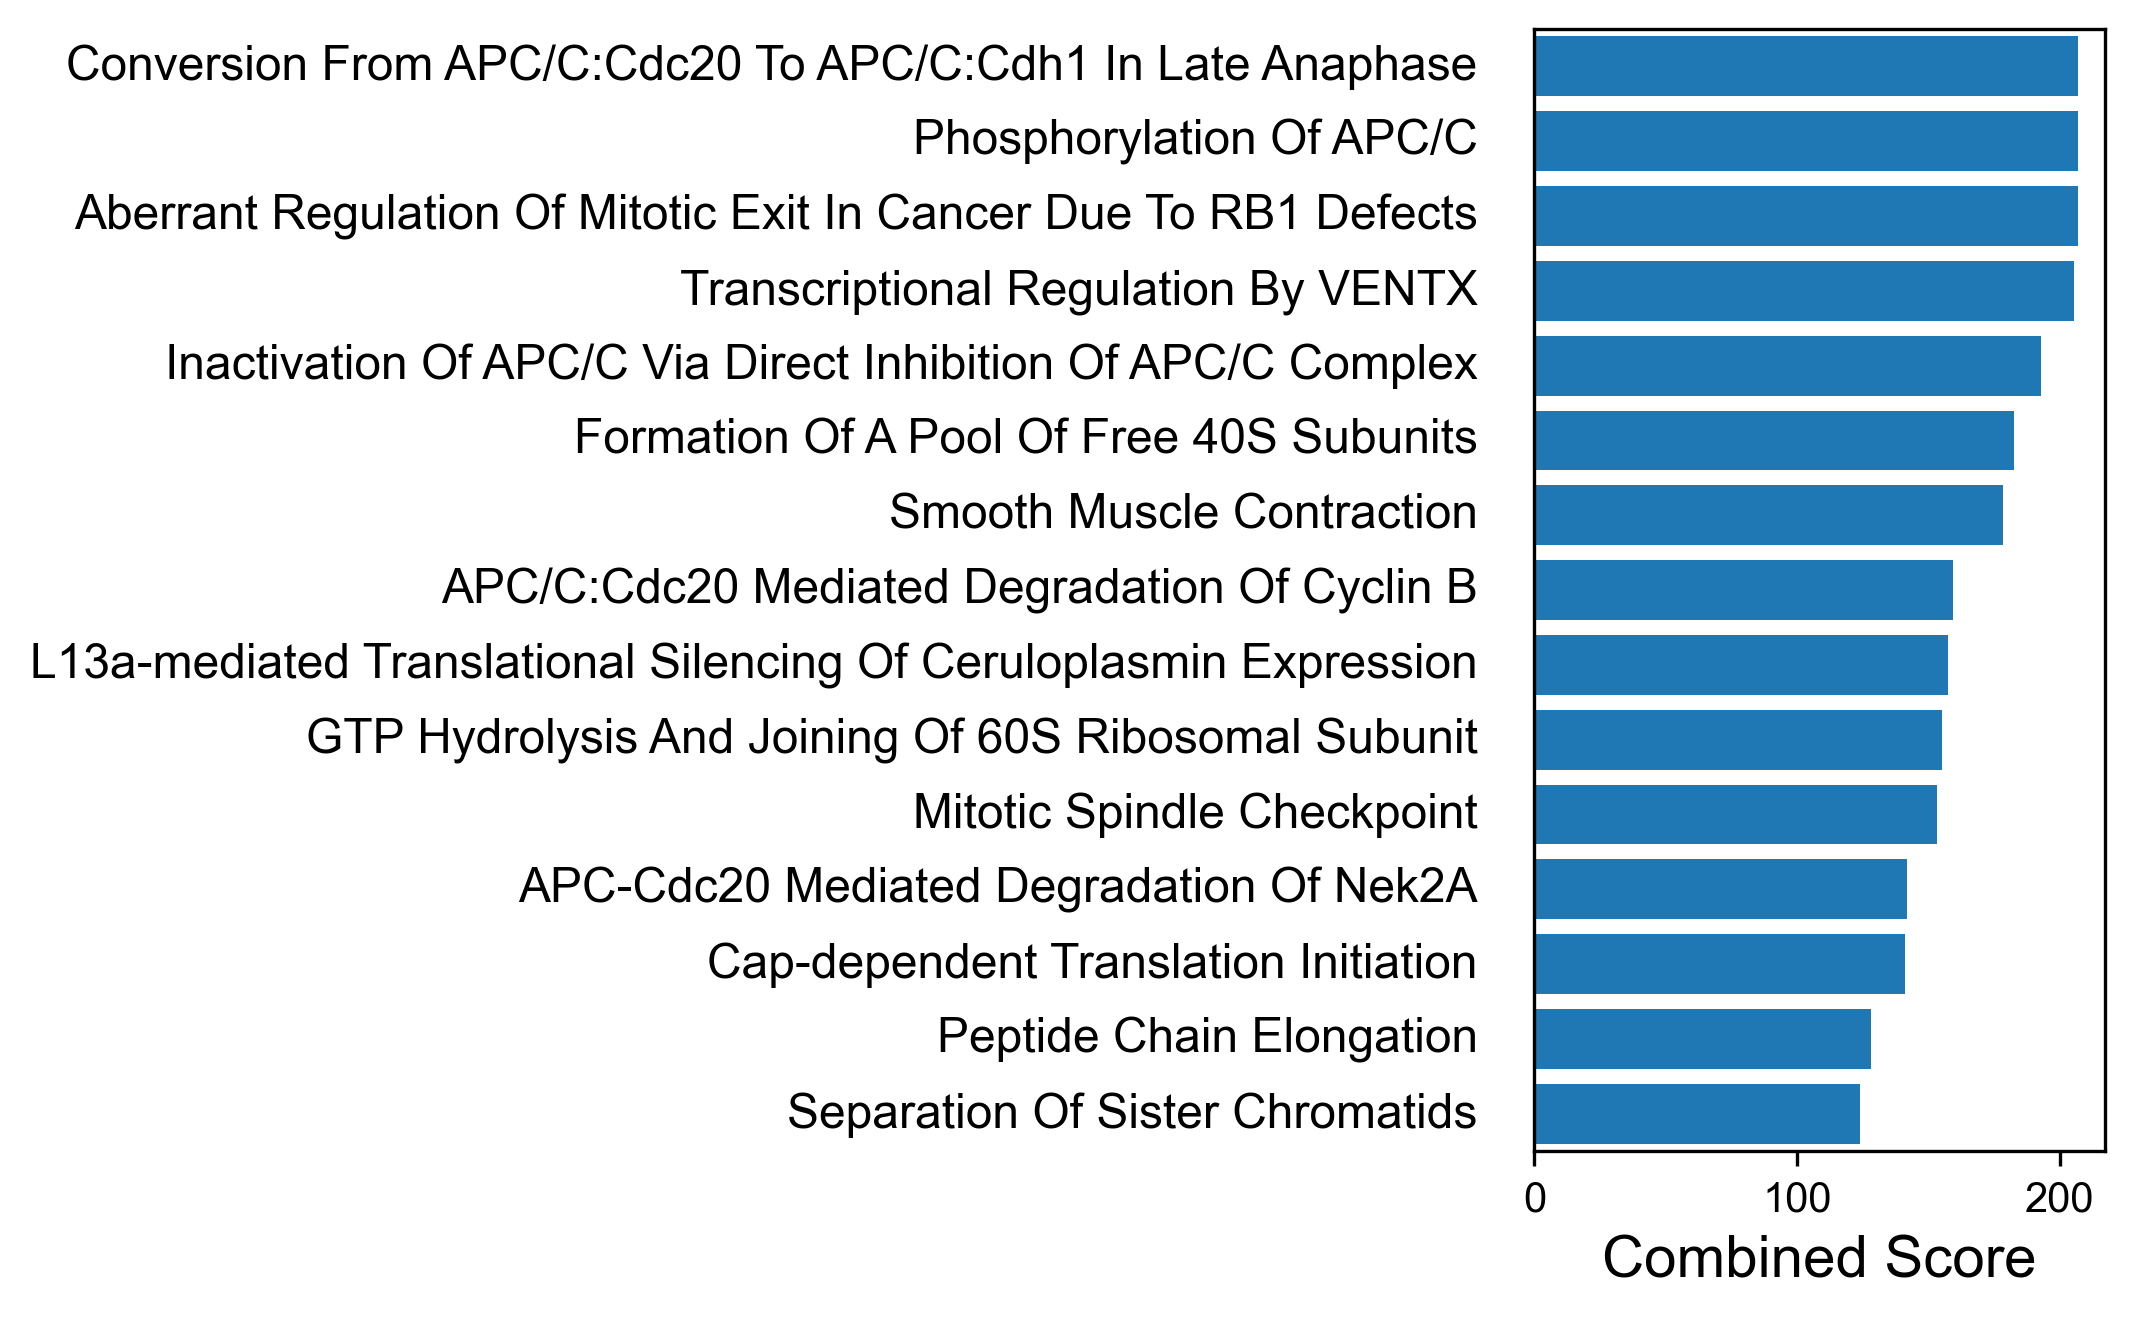

In [32]:
# up pathway enrichment plot
import gseapy as gp
import matplotlib.gridspec as gridspec

n_path = 15

ups = set(df_gene[df_gene['state'] == 'up']['gene'])
enr = gp.enrichr(gene_list=list(ups),
                 gene_sets='Reactome_2022',
                 organism='Human',
                 outdir=None)
df_path = enr.results
df_path = df_path[df_path['Adjusted P-value'] < cut_p]
df_path = df_path.nlargest(n_path, 'Combined Score')

df_path['Term'] = df_path['Term'].str.split(' R-HSA-').str[0]
df_path = df_path.sort_values('Combined Score', ascending=True)
print(df_path['Term'][::-1].str.cat(sep=';'))

terms = df_path['Term'].astype(str).tolist()
scores = df_path['Combined Score'].tolist()
y_pos = np.arange(len(terms))

fig = plt.figure(figsize=(7.5, 4.5))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1.5])

# Left for terms
ax_text = plt.subplot(gs[0])
ax_text.set_xlim(0, 1)
ax_text.set_ylim(-0.5, len(terms) - 0.5)
ax_text.axis('off')
for i, term in enumerate(terms):
    ax_text.text(1.0, i, term, va='center', ha='right', fontsize=11.5)

# Right for scores
ax_bar = plt.subplot(gs[1])
ax_bar.barh(y_pos, scores)
ax_bar.set_yticks([])
ax_bar.set_ylim(-0.5, len(terms) - 0.5)
ax_bar.set_xlabel('Combined Score', fontsize=14)

plt.tight_layout()
plt.show()